# Argo Vertical Spectra

This notebook is based on Dhruv's vertical_spectra notebook with glider data

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import argopy
import scipy.ndimage as filter
import cartopy.crs as ccrs
import cartopy
import xrft
import scipy
import matplotlib

### Glider data, filtering & spectra

In [2]:
ds_660_grid = xr.open_dataset('ctd_660_vert_4m_binned_29_june_2021.nc')
ds_660_grid

<xarray.Dataset>
Dimensions:       (ctd_pressure: 250, dives: 1007)
Coordinates:
  * ctd_pressure  (ctd_pressure) float64 2.0 6.0 10.0 14.0 ... 990.0 994.0 998.0
  * dives         (dives) float64 1.0 1.5 2.0 2.5 ... 508.0 508.5 509.0 509.5
Data variables:
    sigma0        (ctd_pressure, dives) float64 ...
    SA            (ctd_pressure, dives) float64 ...
    CT            (ctd_pressure, dives) float64 ...
    time          (ctd_pressure, dives) datetime64[ns] ...
    latitude      (ctd_pressure, dives) float64 ...
    longitude     (ctd_pressure, dives) float64 ...
Attributes:
    units:          kg/m^3
    comment:        Calculated using GSW
    standard_name:  Potential Density Anomaly
    platform:       glider
    history:        [2021-07-26 18:06:26] (v2021.3) glidertools.cleaning.outl...
    outlier_lims:   [33.83323076 35.65218568]

In [3]:
def glider_ds_filt(ds_interp,first,last,num,variable='CT'):
    temp_sigmas=np.logspace(first,last,num)
    sigmas=np.empty(num)
    for n,sig in enumerate(temp_sigmas):
        sigmas[n]=sig/4/np.sqrt(12)
        
    temp_filt=np.zeros((ds_interp.ctd_pressure.shape[0],ds_interp.dives.shape[0],num))
    for n in range(0,num):
        temp_filt[:,:,n]=filter.gaussian_filter1d(ds_interp[variable],sigma=sigmas[n],mode='nearest')
    ds_filt=xr.DataArray(temp_filt,dims=['ctd_pressure','dives','filt_scale'],
        coords={'ctd_pressure':ds_interp.ctd_pressure,'dives':ds_interp.dives,'filt_scale':sigmas})
    return ds_filt

def glider_var(ds_interp,ds_filt,variable='CT'):
    var=np.zeros(len(ds_filt.filt_scale))
    for n,sig in enumerate(ds_filt.filt_scale):
        prof_filt=ds_filt.sel(filt_scale=sig)
        var[n]=(prof_filt-ds_interp.CT).var()
    return var

In [25]:
ds_660_filt=glider_ds_filt(ds_660_grid,1,4,50)
ds_660_var=glider_var(ds_660_grid,ds_660_filt)

/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, 

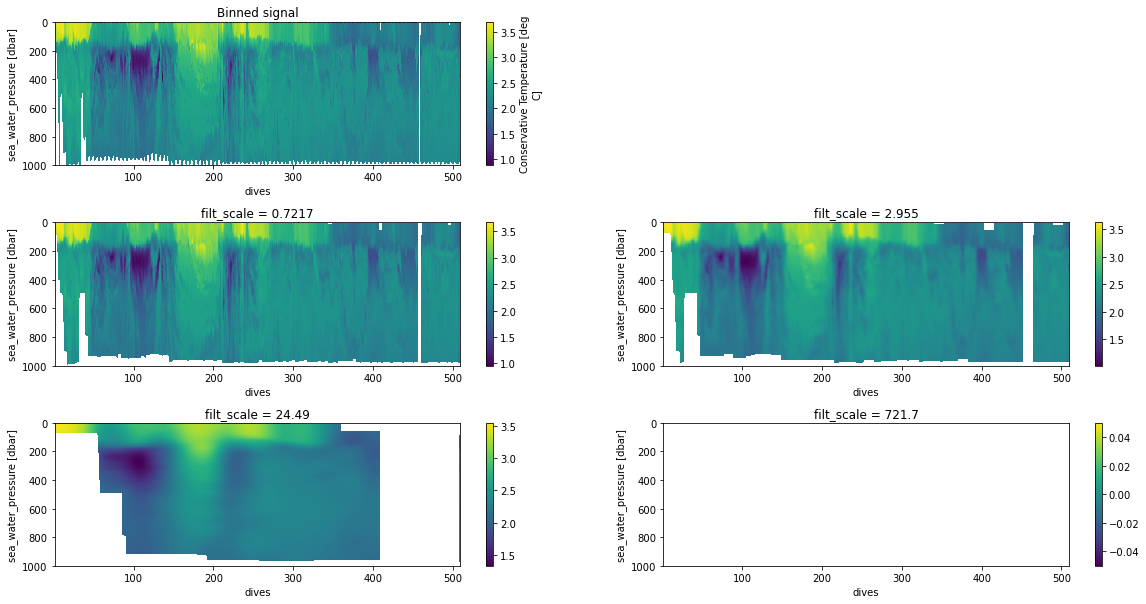

In [26]:
plt.figure(figsize=(20,10))

plt.subplot(3,2,1)
ds_660_grid.CT.plot(x='dives',y='ctd_pressure')
plt.gca().invert_yaxis()
plt.title('Binned signal')

plt.subplot(3,2,3)
ds_660_filt.isel(filt_scale=0).plot()
plt.gca().invert_yaxis()

plt.subplot(3,2,4)
ds_660_filt.isel(filt_scale=10).plot()
plt.gca().invert_yaxis()

plt.subplot(3,2,5)
ds_660_filt.isel(filt_scale=25).plot()
plt.gca().invert_yaxis()

plt.subplot(3,2,6)
ds_660_filt.isel(filt_scale=49).plot()
plt.gca().invert_yaxis()

plt.subplots_adjust(hspace=0.4,wspace=0.2)

In [29]:
select=ds_660_grid.sel(dives=slice(50,450),ctd_pressure=slice(200,900))
select_filt=glider_ds_filt(select,1,3,50)
select_var=glider_var(select,select_filt)

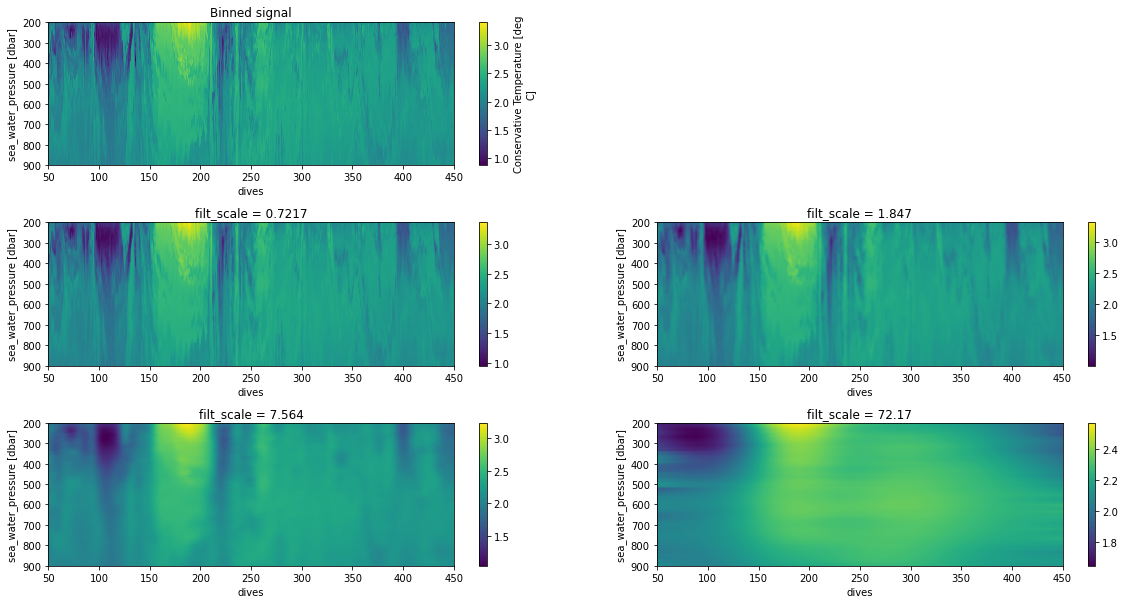

In [30]:
plt.figure(figsize=(20,10))

plt.subplot(3,2,1)
select.CT.plot(x='dives',y='ctd_pressure')
plt.gca().invert_yaxis()
plt.title('Binned signal')

plt.subplot(3,2,3)
select_filt.isel(filt_scale=0).plot()
plt.gca().invert_yaxis()

plt.subplot(3,2,4)
select_filt.isel(filt_scale=10).plot()
plt.gca().invert_yaxis()

plt.subplot(3,2,5)
select_filt.isel(filt_scale=25).plot()
plt.gca().invert_yaxis()

plt.subplot(3,2,6)
select_filt.isel(filt_scale=49).plot()
plt.gca().invert_yaxis()

plt.subplots_adjust(hspace=0.4,wspace=0.2)

Text(0, 0.5, 'Variance ($^oC^2$)')

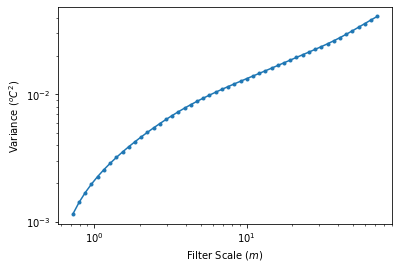

In [37]:
plt.plot(select_filt.filt_scale,select_var,'.-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Filter Scale ($m$)")
plt.ylabel("Variance ($^oC^2$)")

In [38]:
select_CT_spec=xrft.power_spectrum(select.CT.dropna(dim='dives') - select.CT.mean('dives'),
                                     dim='ctd_pressure', window=True)
select_CT_spec

/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


<xarray.DataArray (freq_ctd_pressure: 175, dives: 797)>
array([[2.54320301e-05, 8.84315599e-06, 1.79040715e-03, ...,
        1.44494441e-05, 4.38876162e-06, 7.36626357e-06],
       [7.51697240e-05, 1.23791038e-04, 2.33528706e-04, ...,
        1.69143825e-06, 1.17178170e-06, 2.25081430e-06],
       [1.92254383e-05, 2.31242973e-04, 1.75517310e-03, ...,
        4.44520154e-06, 4.45067752e-06, 2.15557118e-06],
       ...,
       [1.92254383e-05, 2.31242973e-04, 1.75517310e-03, ...,
        4.44520154e-06, 4.45067752e-06, 2.15557118e-06],
       [7.51697240e-05, 1.23791038e-04, 2.33528706e-04, ...,
        1.69143825e-06, 1.17178170e-06, 2.25081430e-06],
       [2.54320301e-05, 8.84315599e-06, 1.79040715e-03, ...,
        1.44494441e-05, 4.38876162e-06, 7.36626357e-06]])
Coordinates:
  * dives              (dives) float64 50.0 50.5 51.0 51.5 ... 449.0 449.5 450.0
  * freq_ctd_pressure  (freq_ctd_pressure) float64 -0.1243 -0.1229 ... 0.1243

Text(0.5, 0, '$\\lambda$ [1/m]')

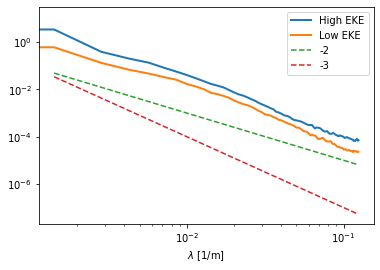

In [39]:
select_CT_spec.sel(dives=slice(0,250)).mean('dives').plot(label='High EKE', linewidth=2)
select_CT_spec.sel(dives=slice(250,500)).mean('dives').plot(label='Low EKE', linewidth=2)

kz = select_CT_spec.freq_ctd_pressure

plt.plot(kz, 1e-7*kz**(-2), '--', label='-2')
plt.plot(kz, 1e-10*kz**(-3), '--', label='-3')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$ [1/m]')

Text(0.5, 0, '$\\lambda$ [1/m]')

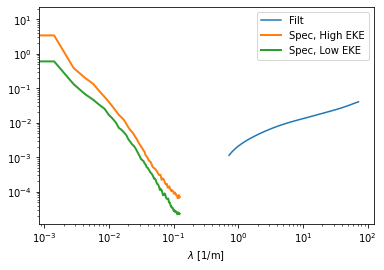

In [53]:
plt.plot(select_filt.filt_scale,select_var,label='Filt')

select_CT_spec.sel(dives=slice(0,250)).mean('dives').plot(label='Spec, High EKE', linewidth=2)
select_CT_spec.sel(dives=slice(250,500)).mean('dives').plot(label='Spec, Low EKE', linewidth=2)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$ [1/m]')

### Argo data, filtering & Spectra

In [103]:
def get_ds_interp(ds,depth_min,depth_max,sample_max):
    median_dp=ds.PRES.where(ds.PRES<depth_max).where(ds.PRES>depth_min).diff('N_LEVELS').median('N_LEVELS')
    ind_rate=median_dp.where(median_dp<sample_max,drop=True).N_PROF
    ds_sel=ds.sel(N_PROF=ind_rate)
    ds_interp=ds_sel.argo.interp_std_levels(np.arange(depth_min,depth_max,2)) #is this where we lose other variables?
    ds_interp=ds_interp.sortby(ds_interp.N_PROF)
    
    number=np.arange(0,len(ds_interp.N_PROF))
    ds_interp.coords['N_PROF_NEW']=xr.DataArray(number,dims=ds_interp.N_PROF.dims)
    return ds_interp

def get_ds_filt(ds_interp,first,last,num,variable='TEMP'):
    temp_sigmas=np.logspace(first,last,num)
    sigmas=np.empty(num)
    for n,sig in enumerate(temp_sigmas):
        sigmas[n]=sig/4/np.sqrt(12)
    
    temp=np.zeros((ds_interp.N_PROF.shape[0],ds_interp.PRES_INTERPOLATED.shape[0],num))
    for n in range(0,num):
        temp[:,:,n]=filter.gaussian_filter1d(ds_interp[variable],sigma=sigmas[n],mode='nearest')

    ds_filt=xr.DataArray(temp,dims=['N_PROF','PRES_INTERPOLATED','FILT_SCALE'],
             coords={'N_PROF':ds_interp.N_PROF,'PRES_INTERPOLATED':ds_interp.PRES_INTERPOLATED,'FILT_SCALE':sigmas})
    
    number=np.arange(0,len(ds_filt.N_PROF))
    ds_filt['N_PROF_NEW']=xr.DataArray(number,dims=ds_filt.N_PROF.dims)
    return ds_filt

def get_var(ds_interp,ds_filt,variable='TEMP'):
    var=np.zeros(len(ds_filt.FILT_SCALE))
    for n,sig in enumerate(ds_filt.FILT_SCALE):
        prof=ds_filt.sel(FILT_SCALE=sig)
        var[n]=(prof-ds_interp[variable]).var()
    return var

In [104]:
box=xr.open_dataset('202206_lon:(30,39)_lat:(-54,-50).nc')

In [113]:
box_interp=get_ds_interp(box,200,1000,4)
box_filt=get_ds_filt(box_interp,1,4,50)
box_var=get_var(box_interp,box_filt)

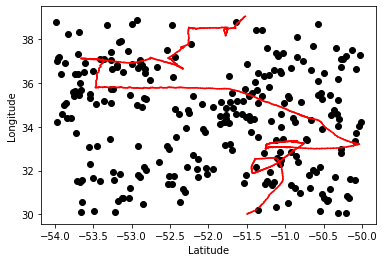

In [114]:
plt.scatter(box_interp.LATITUDE,box_interp.LONGITUDE,color='black',label='argo profiles')
plt.plot(ds_660_grid.latitude, ds_660_grid.longitude,color='r',label='glider path')
plt.xlabel('Latitude')
plt.ylabel('Longitude');

Text(0, 0.5, 'Variance ($^oC^2$)')

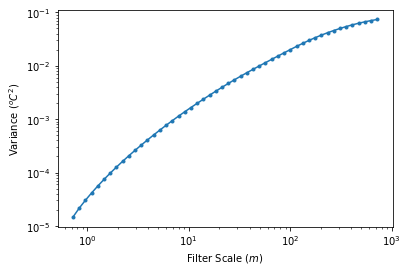

In [116]:
plt.plot(box_filt.FILT_SCALE,box_var,'.-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Filter Scale ($m$)")
plt.ylabel("Variance ($^oC^2$)")

In [121]:
box_TEMP_spec=xrft.power_spectrum(box_interp.TEMP - box_interp.TEMP.mean('N_PROF'),
                                     dim='PRES_INTERPOLATED', window=True)
box_TEMP_spec

/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


<xarray.DataArray (N_PROF: 260, freq_PRES_INTERPOLATED: 400)>
array([[3.71772993e-08, 2.41154217e-07, 4.95427694e-07, ...,
        1.45527398e-06, 4.95427694e-07, 2.41154217e-07],
       [5.51420138e-06, 3.00980285e-07, 3.25803242e-06, ...,
        3.59798846e-06, 3.25803242e-06, 3.00980285e-07],
       [1.33263669e-06, 2.31428924e-07, 9.64549023e-09, ...,
        1.91401481e-06, 9.64549023e-09, 2.31428924e-07],
       ...,
       [2.57451697e-06, 4.65594078e-06, 4.94625242e-06, ...,
        4.00475466e-06, 4.94625242e-06, 4.65594078e-06],
       [6.92123350e-10, 1.13055963e-06, 2.94376904e-06, ...,
        7.87894230e-07, 2.94376904e-06, 1.13055963e-06],
       [1.30082020e-06, 8.54233902e-07, 2.62268051e-06, ...,
        5.90707285e-06, 2.62268051e-06, 8.54233902e-07]])
Coordinates:
  * N_PROF                  (N_PROF) int64 452 454 455 456 ... 1569 1570 1571
    TIME                    (N_PROF) datetime64[ns] 2017-01-14T13:25:03 ... 2...
    LATITUDE                (N_PROF) float64 -50.34 -53.22 ... -51.12 -51.1
    LONGITUDE               (N_PROF) float64 37.57 30.12 30.57 ... 37.37 37.21
    N_PROF_NEW              (N_PROF) int64 0 1 2 3 4 5 ... 255 256 257 258 259
  * freq_PRES_INTERPOLATED  (freq_PRES_INTERPOLATED) float64 -0.25 ... 0.2487

Text(0.5, 0, '$\\lambda$ [1/m]')

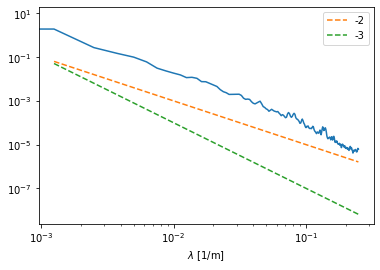

In [122]:
box_TEMP_spec.mean('N_PROF').plot()

kz = box_TEMP_spec.freq_PRES_INTERPOLATED

plt.plot(kz, 1e-7*kz**(-2), '--', label='-2')
plt.plot(kz, 1e-10*kz**(-3), '--', label='-3')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$ [1/m]')